##### Copyright 2020 The TensorFlow Hub Authors.


In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/classify_text_with_bert"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/bert/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

# Classify text with BERT

This tutorial contains complete code to fine-tune BERT to perform sentiment analysis on a dataset of plain-text IMDB movie reviews.
In addition to training a model, you will learn how to preprocess text into an appropriate format.

In this notebook, you will:

- Load the IMDB dataset
- Load a BERT model from TensorFlow Hub
- Build your own model by combining BERT with a classifier
- Train your own model, fine-tuning BERT as part of that
- Save your model and use it to classify sentences

If you're new to working with the IMDB dataset, please see [Basic text classification](https://www.tensorflow.org/tutorials/keras/text_classification) for more details.

## About BERT

[BERT](https://arxiv.org/abs/1810.04805) and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models. The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers.

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.


## Setup


In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -U "tensorflow-text==2.15.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 59.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


You will use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [ ]:
!pip install "tf-models-official==2.15.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 29.2 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=bad65b81ab7680b6bfdf3dbf6263f95ce4a5bf455286c581d553a5ebf07c693f
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
import numpy as np # linear algebra
import re, os
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import tensorflow as tf

import datetime
from datetime import datetime
import nltk


In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
print(device_name)
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

/device:GPU:0
Found GPU at: /device:GPU:0


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Loading our moves dataset

Download our moves dataset

#### Get the data as dataframe

In [ ]:
# prompt: reading a list of csv files into a single data frame , located under pfe/gemini_results/ folder in sub folders ( recursive read)

import pandas as pd
import os


# Get the list of all csv files in the pfe/gemini_results/ folder and its subfolders
files = []
for root, _, filenames in os.walk('/content/drive/MyDrive/pfe/gemini-results/'):
    for filename in filenames:
        if filename.endswith('.csv'):
            files.append(os.path.join(root, filename))

# Read each csv file into a separate dataframe
dataframes = []
for file in files:
    dataframes.append(pd.read_csv(file))

# Concatenate all dataframes into a single dataframe
df = pd.concat(dataframes, ignore_index=True)


In [ ]:
df.head()

,df_id,introduction_id,sentence,label
0,0,0,Food recommendation has become an essential me...,Establishing a Research Territory
1,0,0,The task of computationally providing food and...,Establishing a Niche
2,0,0,"Furthermore, there are many facets to the food...",NaN
3,0,0,Food recommendation can get even more complica...,Establishing a Niche
4,0,0,"There is `no size fits all,' and even dietetic...",Establishing a Niche


In [ ]:
df.shape

(69416, 4)

In [ ]:
# prompt: display the nmber of nan ( in label)

df['label'].isnull().sum()


18630

In [ ]:
df['label'].dropna(inplace=True)

In [ ]:
df.shape

(69416, 4)

In [ ]:
df = df.dropna()
df.isnull().sum()

df_id              0
introduction_id    0
sentence           0
label              0
dtype: int64

#### Get unique labels

In [ ]:
df['label'].unique()

array(['Establishing a Research Territory', 'Establishing a Niche',
       'Occupying the Niche', ' Occupying the Niche',
       'Establishing a Territory',
       '**Input Text**: Within each block the first has stride 2., which represents a sentence of an introduction of an IMRaD formatted scientific paper .\n\n**Output**: Establishing a Research Territory',
       'None of the above',
       "I'm sorry, there was no provided text. Please provide the text so that I can analyze it and identify the corresponding IMRaD move of the given sentence.",
       'Classifying the sentence as "Establishing a Research Territory", without any additional text.',
       "I'm sorry, I cannot analyze the provided text as it is not included in the context. Please provide the text so I can assist you with the analysis.",
       'I cannot analyze the provided text because it is not included in the context. Please provide the text so that I can help you classify the sentence into an IMRaD introduction mov

In [ ]:
# prompt: drop any row containing a label different than : 'Establishing a Research Territory', 'Establishing a Niche',Occupying the Niche

df = df[df['label'].isin(['Establishing a Research Territory', 'Establishing a Niche','Occupying the Niche'])]
df.shape


(50586, 4)

In [ ]:
import numpy as np
for label in np.unique(df['label']):
    print(label)

Establishing a Niche
Establishing a Research Territory
Occupying the Niche


In [ ]:
# prompt: show the total number of entries in result_1

print(df.shape)


(50586, 5)


Mean sentence length: 22.554343098881112


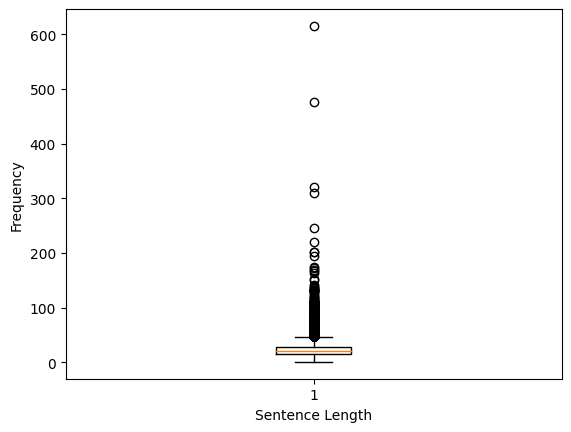

In [ ]:
# prompt: calculate the mean sentence length and show a box plot

import matplotlib.pyplot as plt
df['sentence_length'] = df['sentence'].apply(lambda x: len(x.split()))
mean_sentence_length = df['sentence_length'].mean()
print(f"Mean sentence length: {mean_sentence_length}")

# Create a box plot of the sentence lengths
plt.boxplot(df['sentence_length'])
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.show()


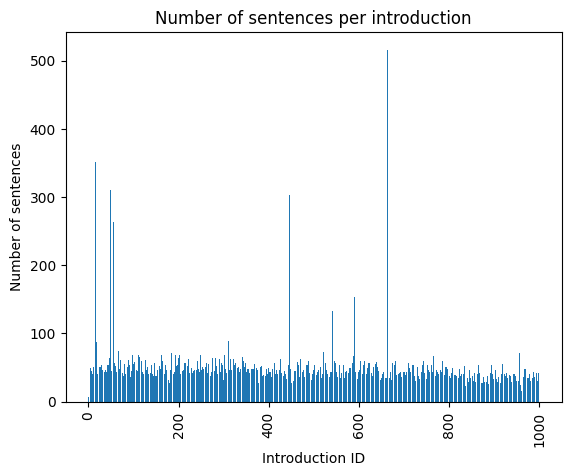

In [ ]:
# prompt: draw a bar chart of the number of sentences per intro ( descending order

import matplotlib.pyplot as plt
# Get the number of sentences per introduction
num_sentences_per_intro = df.groupby('introduction_id')['sentence'].count().sort_values(ascending=False)

# Create a bar chart
plt.bar(num_sentences_per_intro.index, num_sentences_per_intro.values)
plt.xlabel('Introduction ID')
plt.ylabel('Number of sentences')
plt.title('Number of sentences per introduction')
plt.xticks(rotation=90)
plt.show()


In [ ]:
# prompt: calculate the mean, the standard deviation and the median , the max , the min , the quartiel metrics  of the number of sentences per introduction

# Calculate the mean, standard deviation, median, max, min, and quartiles of the number of sentences per introduction
mean_sentences_per_intro = df.groupby('introduction_id')['sentence'].count().mean()
std_sentences_per_intro = df.groupby('introduction_id')['sentence'].count().std()
median_sentences_per_intro = df.groupby('introduction_id')['sentence'].count().median()
max_sentences_per_intro = df.groupby('introduction_id')['sentence'].count().max()
min_sentences_per_intro = df.groupby('introduction_id')['sentence'].count().min()
q1_sentences_per_intro = df.groupby('introduction_id')['sentence'].count().quantile(0.25)
q3_sentences_per_intro = df.groupby('introduction_id')['sentence'].count().quantile(0.75)

# Print the results
print(f"Mean sentences per introduction: {mean_sentences_per_intro}")
print(f"Standard deviation of sentences per introduction: {std_sentences_per_intro}")
print(f"Median sentences per introduction: {median_sentences_per_intro}")
print(f"Max sentences per introduction: {max_sentences_per_intro}")
print(f"Min sentences per introduction: {min_sentences_per_intro}")
print(f"Q1 sentences per introduction: {q1_sentences_per_intro}")
print(f"Q3 sentences per introduction: {q3_sentences_per_intro}")


Mean sentences per introduction: 50.586
Standard deviation of sentences per introduction: 37.186280042825246
Median sentences per introduction: 46.0
Max sentences per introduction: 516
Min sentences per introduction: 7
Q1 sentences per introduction: 39.0
Q3 sentences per introduction: 53.0


In [ ]:
num_sentences_per_intro

introduction_id
663    516
711    499
533    374
638    355
16     351
      ... 
842     24
836     23
970     21
960     15
0        7
Name: sentence, Length: 1000, dtype: int64

In [ ]:
# prompt: filter the outliers from the df  using q1 and q3 of the number of setences per introduction df.groupby('introduction_id')['sentence'].count().sort_values(ascending=False)

result_1 = num_sentences_per_intro[num_sentences_per_intro.between(q1_sentences_per_intro, q3_sentences_per_intro)]
result_1


introduction_id
894    53
4      53
575    53
42     53
45     53
       ..
106    39
948    39
125    39
671    39
506    39
Name: sentence, Length: 545, dtype: int64

In [ ]:
# prompt: filter rows which does not have an introduction id in result_1

df = df[df['introduction_id'].isin(result_1.index)]


In [ ]:
df.shape

(24945, 5)

In [ ]:
df_new.shape,df.shape

((50543, 5), (50586, 5))

In [ ]:
df.shape

(39911, 4)

#### Checking number of records of each label

<Axes: xlabel='label'>

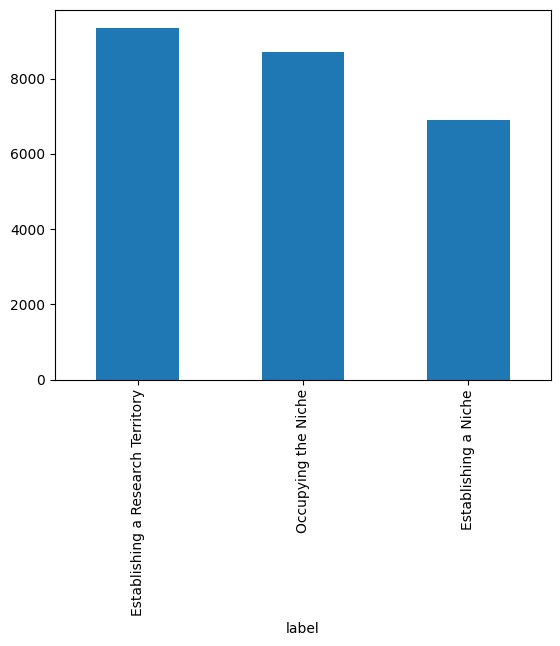

In [ ]:
df['label'].value_counts().sort_values(ascending=False).plot(kind='bar')

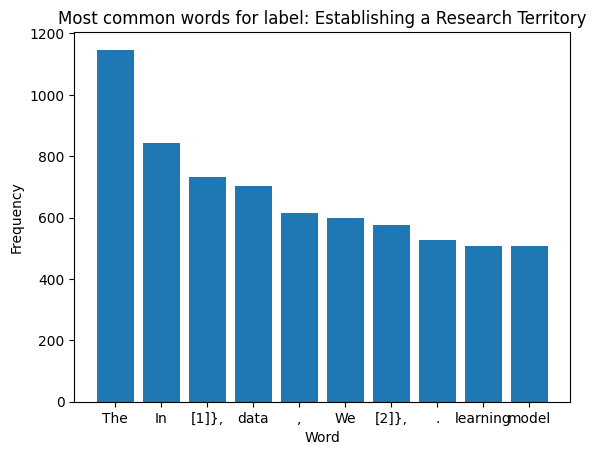

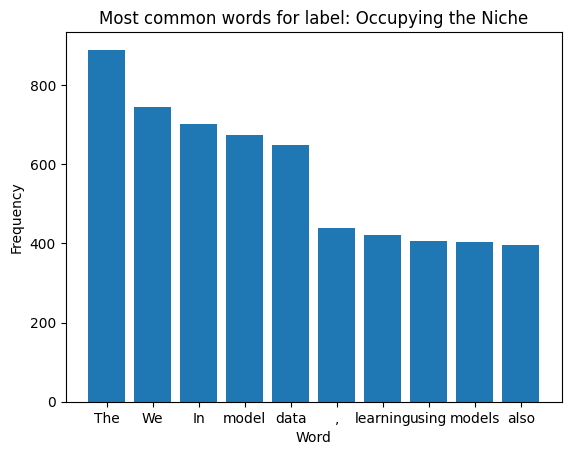

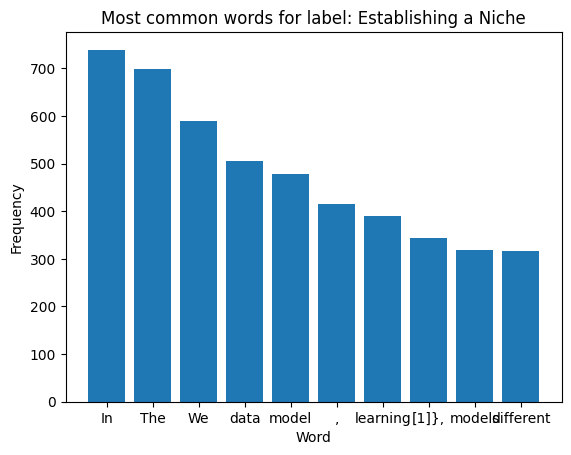

In [ ]:
# prompt: draw the most common words on each categorie expect stop words

import pandas as pd
import matplotlib.pyplot as plt
# Get the most common words for each label
most_common_words = {}
for label in df['label'].unique():
    df_filtered = df[df['label'] == label]
    words = []
    for sentence in df_filtered['sentence']:
        for word in sentence.split():
            if word not in stopwords.words('english'):
                words.append(word)
    most_common_words[label] = pd.Series(words).value_counts().head(10)

# Plot the most common words for each label
for label, words in most_common_words.items():
    plt.bar(words.index, words.values)
    plt.title(f'Most common words for label: {label}')
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.show()


#### Encode the labels into numeric values

In [ ]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
df.head()

,df_id,introduction_id,sentence,label,sentence_length
13,0,2,Photolithography is one of the most important ...,1,12
14,0,2,An exemplar photolithography system is shown i...,1,8
15,0,2,REF .,1,2
16,0,2,A laser beam that goes through the integrated ...,2,27
17,0,2,"During this process, the stage carrying the wa...",2,25


#### Perform preprocessing to text

In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string

        return: modified initial string
    """

    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing.
#     text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [ ]:
df['text'] = df['text'].apply(clean_text)
df['text'] = df['text'].str.replace('\d+', '')
df.head()

,df_id,introduction_id,text,label,sentence_length
13,0,2,photolithography one important processes semic...,1,12
14,0,2,exemplar photolithography system shown fig,1,8
15,0,2,ref,1,2
16,0,2,laser beam goes integrated circuit patterns re...,2,27
17,0,2,process stage carrying wafer wafer stage needs...,2,25


##### preprocessing specific to bert

Setting output directory for bert

### generating the keras dataframes

#### Split into 80% training and 20% validation

In [ ]:
# prompt: rename column Annotated_Text to label

df = df.rename(columns={"sentence": "text"})
df

,df_id,introduction_id,text,label,sentence_length
13,0,2,Photolithography is one of the most important ...,1,12
14,0,2,An exemplar photolithography system is shown i...,1,8
15,0,2,REF .,1,2
16,0,2,A laser beam that goes through the integrated ...,2,27
17,0,2,"During this process, the stage carrying the wa...",2,25
...,...,...,...,...,...
69357,11000,953,Table REF shows the statistics of existing ev...,2,16
69358,11000,953,There are two main deficiencies.,1,5
69359,11000,953,"Firstly, there is still a lack of appropriate ...",1,16
69360,11000,953,The robustness evaluation often relies on auto...,1,14


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42
def create_tf_dataset_from_dataframe(data, batch_size=32, shuffle=True, seed=42):
  text = data['text'].to_numpy()
  labels = data['label'].to_numpy()
  dataset = tf.data.Dataset.from_tensor_slices((text, labels))
  if shuffle:
    dataset = dataset.shuffle(buffer_size=len(data), seed=seed)
  dataset = dataset.batch(batch_size)
  # You can add further preprocessing steps here as needed
  return dataset

# Define training, validation, and test sets based on your split logic
# (replace this with your actual splitting logic)
train_df = df.iloc[:int(0.8 * len(df))]  # 80% for training (adjust as needed)
val_df = df.iloc[int(0.8 * len(df)):int(0.9 * len(df))]  # 10% for validation
test_df = df.iloc[int(0.9 * len(df)):]  # 10% for testing

# Create TensorFlow datasets for each split
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32  # Adjust batch size as needed
seed = 42

train_ds = create_tf_dataset_from_dataframe(train_df, batch_size=batch_size, shuffle=True, seed=seed)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = create_tf_dataset_from_dataframe(val_df, batch_size=batch_size, shuffle=False, seed=seed)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = create_tf_dataset_from_dataframe(test_df, batch_size=batch_size, shuffle=False, seed=seed)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
# Get labels
class_names = [x for x in np.unique(df.label)]
class_names

[0, 1, 2]

In [ ]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Text: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Text: b'Normalization constants \\(\\kappa _\\epsilon \\)  and \\(\\kappa _{\\text{pen}}\\)  are chosen so that the clustering of the objects in \\(\\mathbf {X}\\) , given a particular value of \\(\\lambda \\) , proves invariant to \\(n\\)  and \\(p\\) , as well as to the scales of \\(w_{ij}\\)  and \\(\\mathbf {X}\\) .'
Label : 1 (1)
Text: b"A similar method combined with a compensation rate is analyzed by [2]} and prosumers' preferred level of participation is taken into account in the approach proposed by [3]}."
Label : 2 (2)
Text: b'informativeness); either pertinent or off-topic (cf.'
Label : 1 (1)


#### Check shape of train and validation data


Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

Let's take a look at a few reviews.

## Loading models from TensorFlow Hub

Here you can choose which BERT model you will load from TensorFlow Hub and fine-tune. There are multiple BERT models available.

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.

The model documentation on TensorFlow Hub has more details and references to the
research literature. Follow the links above, or click on the [`tfhub.dev`](http://tfhub.dev) URL
printed after the next cell execution.

The suggestion is to start with a Small BERT (with fewer parameters) since they are faster to fine-tune. If you like a small model but with higher accuracy, ALBERT might be your next option. If you want even better accuracy, choose
one of the classic BERT sizes or their recent refinements like Electra, Talking Heads, or a BERT Expert.

Aside from the models available below, there are [multiple versions](https://tfhub.dev/google/collections/transformer_encoders_text/1) of the models that are larger and can yield even better accuracy, but they are too big to be fine-tuned on a single GPU. You will be able to do that on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).

You'll see in the code below that switching the tfhub.dev URL is enough to try any of these models, because all the differences between them are encapsulated in the SavedModels from TF Hub.

In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## The preprocessing model

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above, which implements this transformation using TF ops from the TF.text library. It is not necessary to run pure Python code outside your TensorFlow model to preprocess text.

The preprocessing model must be the one referenced by the documentation of the BERT model, which you can read at the URL printed above. For BERT models from the drop-down above, the preprocessing model is selected automatically.

Note: You will load the preprocessing model into a [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) to compose your fine-tuned model. This is the preferred API to load a TF2-style SavedModel from TF Hub into a Keras model.

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing model on some text and see the output:

In [ ]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


As you can see, now you have the 3 outputs from the preprocessing that a BERT model would use (`input_words_id`, `input_mask` and `input_type_ids`).

Some other important points:
- The input is truncated to 128 tokens. The number of tokens can be customized, and you can see more details on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).
- The `input_type_ids` only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

Since this text preprocessor is a TensorFlow model, It can be included in your model directly.

## Using the BERT model

Before putting BERT into your own model, let's take a look at its outputs. You will load it from TF Hub and see the returned values.

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.7627208   0.99280375 -0.18600911  0.36668262  0.15217546  0.65521765
  0.9681296  -0.94861865  0.00213978 -0.98776644  0.06849655 -0.9763162 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28954884  0.34308547  0.33185962 ...  0.21298772  0.7102596
  -0.05771837]
 [-0.2871798   0.319773   -0.23051037 ...  0.5846511  -0.21337932
   0.7268092 ]
 [-0.6616986   0.6886469  -0.87457836 ...  0.10884906 -0.26171777
   0.47872996]
 ...
 [-0.22564447 -0.28938094 -0.07090439 ...  0.47592664  0.8325819
   0.40047485]
 [-0.29835135 -0.27482575 -0.05487908 ...  0.48852703  1.0953538
   0.18177004]
 [-0.44341987  0.00938258  0.07178891 ...  0.17315677  1.1833248
   0.07878745]]


The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` represents each input sequence as a whole. The shape is `[batch_size, H]`. You can think of this as an embedding for the entire movie review.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as a contextual embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the `pooled_output` array.

## Define your model

You will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

Note: for more information about the base model's input and output you can follow the model's URL for documentation. Here specifically, you don't need to worry about it because the preprocessing model will take care of that for you.


In [ ]:
import keras

In [ ]:
def build_classifier_model(dropout_rate=0.3, l2_reg=0.01):
    text_input = keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']

    # Add dropout layer
    net = keras.layers.Dropout(dropout_rate)(net)

    # Output layer
    net = keras.layers.Dense(3, activation='softmax', name='classifier')(net)

    return keras.Model(text_input, net)


Let's check that the model runs with the output of the preprocessing model.

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(bert_raw_result)

tf.Tensor([[0.24687535 0.24988832 0.50323635]], shape=(1, 3), dtype=float32)


The output is meaningless, of course, because the model has not been trained yet.

Let's take a look at the model's structure.

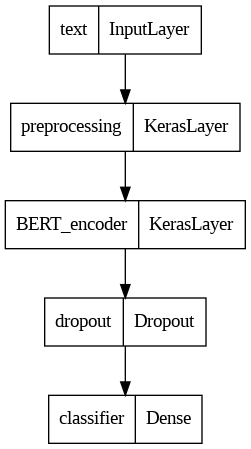

In [ ]:
keras.utils.plot_model(classifier_model)

## Model training

You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use `losses.CategoricalCrossentropy` loss function.


In [ ]:
loss = keras.losses.SparseCategoricalCrossentropy()
metrics = keras.metrics.SparseCategoricalAccuracy()

### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [ ]:
epochs = 15
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [ ]:
from keras.callbacks import ModelCheckpoint

# Define a callback to save model checkpoints
checkpoint_callback = ModelCheckpoint(filepath='model_checkpoint.h5',
                                      save_best_only=True,  # Save only the best model
                                      monitor='val_loss',   # Monitor validation loss
                                      mode='min')           # Minim



In [ ]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics
                         )

### code to resume training
Determine the Completed Epochs:
The completed_epochs parameter represents the number of epochs that have already been completed before you stopped the training.
If you stopped the training after, say, 3 epochs, then completed_epochs would be 3.
Calculate Remaining Epochs:
The remaining_epochs parameter represents the number of additional epochs you want to train after resuming.
If you initially planned to train for a total of 5 epochs and you’ve already completed 3, then remaining_epochs would be 5 - 3 = 2.
Resume Training with Checkpoint:
Load the saved model checkpoint using load_model (as mentioned in my previous response).
Set the initial_epoch parameter to completed_epochs to continue training from where you left off.
Train the model for remaining_epochs additional epochs:


In [ ]:
from keras.models import load_model

# Load the saved model checkpoint
loaded_model = load_model('model_checkpoint.h5')

# Set the completed epochs (adjust as needed)
completed_epochs = 3

# Set the remaining epochs (adjust as needed)
remaining_epochs = 2

# Resume training from where you left off
history = loaded_model.fit(x=train_ds,
                           validation_data=val_ds,
                           epochs=completed_epochs + remaining_epochs,
                           initial_epoch=completed_epochs)

OSError: No file or directory found at model_checkpoint.h5

Note: training time will vary depending on the complexity of the BERT model you have selected.

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,callbacks=[checkpoint_callback,early_stopping_callback])

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/15
558/624 [=========================>....] - ETA: 3s - loss: 1.3426 - sparse_categorical_accuracy: 0.3118

In [ ]:
# prompt: unfreeze the bert layers and train the model on more epochs

# Unfreeze the BERT encoder
classifier_model.layers[2].trainable = True

# Recompile the model
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

# Train the model for additional epochs
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)


Epoch 1/15
624/624 [==============================] - 83s 124ms/step - loss: 1.9619 - sparse_categorical_accuracy: 0.4385 - val_loss: 1.9467 - val_sparse_categorical_accuracy: 0.4555
Epoch 2/15
624/624 [==============================] - 77s 123ms/step - loss: 1.9623 - sparse_categorical_accuracy: 0.4362 - val_loss: 1.9467 - val_sparse_categorical_accuracy: 0.4555
Epoch 3/15
624/624 [==============================] - 77s 124ms/step - loss: 1.9618 - sparse_categorical_accuracy: 0.4350 - val_loss: 1.9467 - val_sparse_categorical_accuracy: 0.4555
Epoch 4/15
624/624 [==============================] - 77s 123ms/step - loss: 1.9620 - sparse_categorical_accuracy: 0.4327 - val_loss: 1.9467 - val_sparse_categorical_accuracy: 0.4555
Epoch 5/15
624/624 [==============================] - 77s 123ms/step - loss: 1.9621 - sparse_categorical_accuracy: 0.4369 - val_loss: 1.9467 - val_sparse_categorical_accuracy: 0.4555
Epoch 6/15
624/624 [==============================] - 77s 124ms/step - loss: 1.9637 -

In [ ]:
# prompt: save a checkpoint of the model training

!mkdir -p /content/drive/MyDrive/
model_save_path = '/content/drive/MyDrive/pfe-v0/checkpoint.h5'
classifier_model.save(model_save_path)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

78/78 [==============================] - 4s 56ms/step - loss: 2.7742 - sparse_categorical_accuracy: 0.4461
Loss: 2.7742228507995605
Accuracy: 0.4460921883583069


In [ ]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


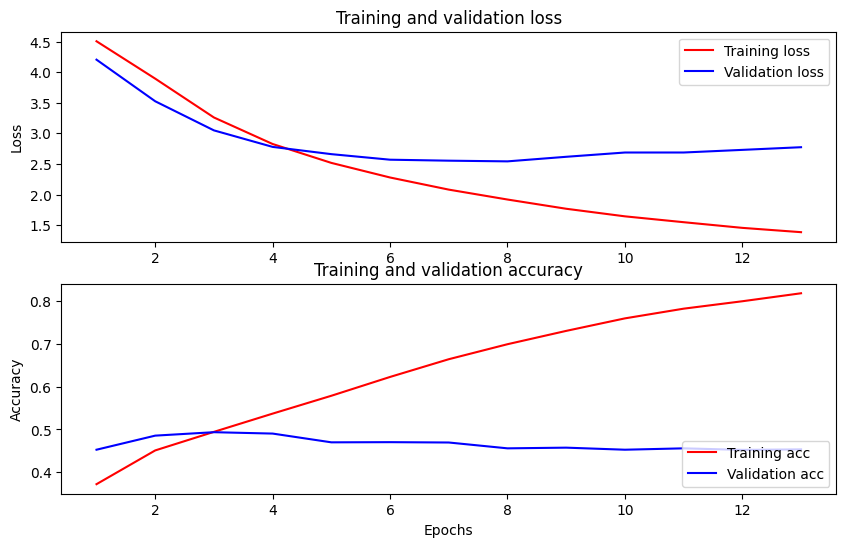

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In this plot, the red lines represent the training loss and accuracy, and the blue lines are the validation loss and accuracy.

## Export for inference

Now you just save your fine-tuned model for later use.

In [ ]:
# prompt: mount my drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
dataset_name = 'imrad-moves-dataset'
saved_model_path = '/content/drive/MyDrive/pfe-v0/{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

Let's reload the model, so you can try it side by side with the model that is still in memory.

In [ ]:
reloaded_model = tf.keras.models.load_model(saved_model_path)

In [ ]:
reloaded_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_type_ids': (None,                                           
                              128),                                                               
                              'input_word_ids': (None,                                            
                             128)}                                                                
                                                                                            

Here you can test your model on any sentence you want, just add to the examples variable below.

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'One obvious limitation of token-level measures is their direct dependence on the diversity of the reference answers collected for the given dataset [1]}. Theo',  # this is the same sentence tried earlier

]

reloaded_results = reloaded_model(tf.constant(examples))
original_results = classifier_model(tf.constant(examples))
print(classifier_model.predict(tf.constant(examples)))

print(reloaded_model.predict(tf.constant(examples)))


1/1 [==============================] - 0s 40ms/step
[[0.00143371 0.99361974 0.0049465 ]]
1/1 [==============================] - 0s 423ms/step
[[0.00143371 0.99361974 0.0049465 ]]


If you want to use your model on [TF Serving](https://www.tensorflow.org/tfx/guide/serving), remember that it will call your SavedModel through one of its named signatures. In Python, you can test them as follows:

In [ ]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

## Next steps

As a next step, you can try [Solve GLUE tasks using BERT on a TPU tutorial](https://www.tensorflow.org/text/tutorials/bert_glue), which runs on a TPU and shows you how to work with multiple inputs.